<a href="https://colab.research.google.com/github/sabymon/sabymon/blob/main/SimPy_Discrete_Event_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Simpy- Discrete Event Simulation (DES)


1. DES assumes events happen at specified intervals
 - No change of system in between events
 - Variables change at set intervals
 - Event is an instanteneous occurance that may change the state of a system.
2. Next-event time advance (NETA): State variables updated and future events are scheduled when an event occurs.
3. Fixed-increment time advance (FITA):Move simulation clock based on time t interval.
https://colab.research.google.com/github/larakattan/intro_to_simpy/blob/main/intro-to-simpy-Lara-Kattan-PyData-Global-22.ipynb#scrollTo=handed-contrary
- Author: Lara Kattan (NYC 2022)

Queing Theory:
Kendall Notation (1953): ASC
- A: A is time b/w arrivals to the queue (interarrival time)
- S: S is the service time distribution
- C: C is the number of sercive channel open at the node

In [ ]:
!pip install simpy
!pip install simpy_helpers
# helpers help get the final report
# Imports
import simpy
from simpy_helpers import Entity, Resource, Source, Stats
import numpy as np # numpy will be used for randomness and distribution methods
import matplotlib.pyplot as plt
import seaborn as sns

Simplest Queue: M/M/1
- M: Poisson process (or random) arrival process(eg; exponential inter-arrival time)
- M: Exponential service Time (Fixed or Distribution)
- 1: Single Server (Finite or Infinite Queue)
- Arrival at rate(λ) ̐move the process from state i to i+1
- Service times have an exponential distribution with a rate parameter mu (μ) - 1/(μ) mean service time.
- Note: Arrival and service times are assumed to be independent
A single server serves one customer at a time, based on first come first serve disciplined (FIFO). The buffer is of infinite size, so there is no limit on number of customer it can obtain.

### M/M/1 Queue simulation
- **Entity**: The thing passing through the simulation (customer, widget, car)
  1. Has attributes, including preferences and priority
  2. Entities track their journey in the simulation, incl time waiting for a resource and processing time at a resource
- **Resource**: Entity requests a service from a resource
  1. Capacity: number of entities that can recieve services simultaneously before a queue forms
  2. Entities can visit multiple resources in their time in simulation
- **Source**: Defines entities based on a template (attributes,including priority)
  1. Feeds entities into simulation
  2. Defines interarrival time (time between entities enterin the simulation)
  3. Interarrival can be fixed or drawn from a simulation

  - Theoritical average time in system = 1/ (μ-λ)
   > μ = average service rate, 1/mean service time
    - λ = average arrival rate, 1/ mean arrival rate

### Specify Constants
- In caps as convention

In [ ]:
NUM_ENTITIES = 10000
MEAN_TIME_BETWEEN_ARRIVALS = 30
MEAN_SERVICE_TIME = 50
SIM_LENGTH = 200000

### Define Entity Class

This class controls how an entity proceeds through a simulation. That is, what resources it visits and how much time it spends at each resource. You must define a process ()
 method (again based on simpy_helpers)

In [ ]:
#How an entity proceeds through the simulation
class runJob(Entity):

  def process(self):
      # first, wait for space to open up at a resource
      yield self.wait_for_resource(my_resource)
      # then process at the resouce
      # we will define the resource in the next step
      yield self.process_at_resource(my_resource)

      # leave the resource and open up a spot for the next entity
      self.release_resource(my_resource) #Once process ends entity leaves the simulation





### Define the Resource Class

We have to define a service_time method that tells us how long each entity spends at a resource

In [ ]:
class myResource(Resource):

  def service_time(self,entity):
    # We would define this as fixed or stochastic time
    # when using stochastic, it is often modeled as draw from an exponential distribution
    return np.random.exponential(MEAN_SERVICE_TIME) #Mean_Service_Time is a constant defined by user


### Define Source Class

We have to define an interval_time that tells us how long between entities arriving to the simulation.
We also have to define a build_entity that creates the customer entering the simulation and sets their attributes. Priority defaults to 1. Lower number are higher priority.

In [ ]:
class generateCustomers(Source):

  def interarrival_time(self):
    # time between each entity arriving; also modeled as
    # as a draw from an exponential
    return np.random.exponential(MEAN_TIME_BETWEEN_ARRIVALS)

  def build_entity(self):
    attributes = {}
    attributes['customer'] = np.random.choice(['standard','priority'])
    if attributes['customer'] == 'priority':
       attributes['priority'] = 0
#Default priority 1, lower the number higher priority
  #remember we defined the runJob class in step 1
    return runJob(env, attributes)


### Run Simulation

In [ ]:
# setting a random seed will ensure that our pseudo randomness is replicable
np.random.seed(34)

# the environment that will run the whole simulation
env = simpy.Environment()
# create a resource object and set its capacity
# recall that myResource inherits the resource class from simpy_help
# capacity is the number of entities that can receive service simultaneously
# here we are modeling M/M/1
my_resource = myResource(env, capacity = 2)


# Specify the number of Jobs
my_source = generateCustomers(env, number = NUM_ENTITIES)


# kick off the simulation with source class that generates jobs/customer

env.process(my_source.start(debug = False))

# Run the simulation
env.run()


### Using simpy_helpers to get statistics on the simulation

In [ ]:
Stats.get_total_times()[:5]

[30.063031988131016,
 42.954373497010614,
 103.59603001205181,
 42.41561065173918,
 64.2694357267862]

In [ ]:
print(f"Customer average time in simulation = {np.mean(Stats.get_total_times()):0.5} ")
print(f"Customer average time waiting = {np.mean(Stats.get_waiting_times()):0.5} ")
print(f"Customer average time processing = {np.mean(Stats.get_processing_times()):0.5} ")

Customer average time in simulation = 32.641 
Customer average time waiting = 2.7083 
Customer average time processing = 29.933 


In [ ]:
print(f"Customer average time waiting (standard) = {np.mean(Stats.get_waiting_times(my_resource, attributes={'customer': 'standard'})):0.6} ")
print(f"Customer average time waiting (priority) = {np.mean(Stats.get_waiting_times(my_resource, attributes={'customer': 'priority'})):0.5} ")
print(f"Resource average processing time = {np.mean(Stats.get_processing_times(my_resource)):0.5} ")

Customer average time waiting (standard) = 2.91331 
Customer average time waiting (priority) = 2.5063 
Resource average processing time = 29.933 


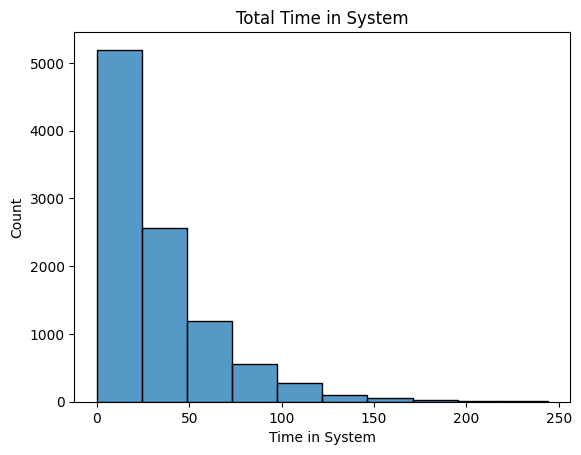

In [ ]:
system_times = Stats.get_total_times()

sns.histplot(system_times,bins=10)
plt.xlabel('Time in System')
plt.title("Total Time in System");

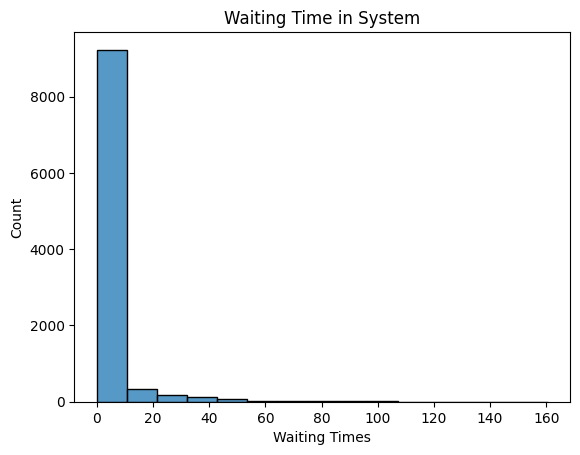

In [ ]:
waiting_times = Stats.get_waiting_times()

sns.histplot(waiting_times)
plt.xlabel('Waiting Times')
plt.title("Waiting Time in System");

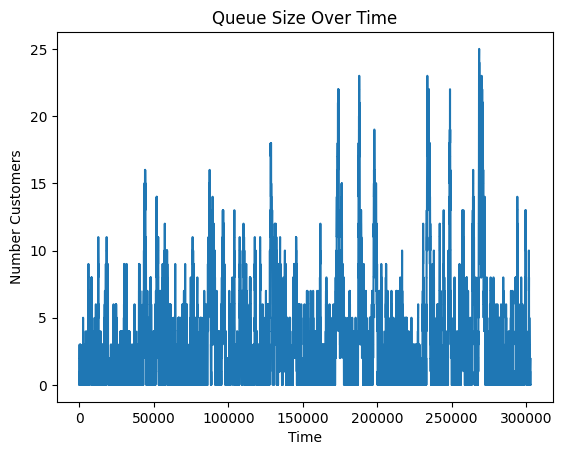

In [ ]:
resource_queue = Stats.queue_size_over_time(my_resource)
sns.lineplot(y=resource_queue,x=range(0,len(resource_queue)))
plt.title("Queue Size Over Time")
plt.xlabel("Time")
plt.ylabel("Number Customers");